In [1]:
import numpy as np
import sympy as sp
import scipy.spatial
from tectosaur2.mesh import build_interp_matrix, gauss_rule, refine_surfaces, concat_meshes, build_interpolator

In [2]:
qx, qw = gauss_rule(6)


In [3]:
sp_t = sp.var('t')
def sp_line(start, end):
    t01 = (sp_t + 1) * 0.5
    xv = start[0] + t01 * (end[0] - start[0])
    yv = start[1] + t01 * (end[1] - start[1])
    return sp_t, xv, yv


A, B = refine_surfaces(
    [
        sp_line([0, 0], [10, -1]),
        sp_line([0, 0], [13, 0]),
    ],
    (qx, qw),
    control_points=[(0, 0, 1.0, 1.0)],
)

In [11]:
obs_pts = A.pts
safety_mode = True
combined_src = concat_meshes((A,B))

singularities= np.array([[0,0]])
if singularities is not None:
    singularity_tree = scipy.spatial.KDTree(
        np.asarray(singularities, dtype=np.float64)
    )

src_tree = scipy.spatial.KDTree(combined_src.pts)
closest_dist, closest_idx = src_tree.query(obs_pts)
closest_panel_length = combined_src.panel_length[
    closest_idx // combined_src.panel_order
]

use_qbx = np.ones((obs_pts.shape[0]), dtype=bool)
n_qbx = obs_pts.shape[0]
qbx_obs_pts = obs_pts[use_qbx]
qbx_src_pt_indices = closest_idx[use_qbx]
qbx_closest_pts = combined_src.pts[qbx_src_pt_indices]
qbx_normals = combined_src.normals[qbx_src_pt_indices]
qbx_panel_L = closest_panel_length[use_qbx]

# step 3: find expansion centers
exp_rs = qbx_panel_L * 0.5

direction_dot = (
    np.sum(qbx_normals * (qbx_obs_pts - qbx_closest_pts), axis=1) / exp_rs
)
direction = np.sign(direction_dot)
on_surface = np.abs(direction) < 1e-13

# TODO: it would be possible to implement a limit_direction='best'
# option that chooses the side that allows the expansion point to be
# further from the source surfaces and then returns the side used. then,
# external knowledge of the integral equation could be used to handle
# the jump relation and gather the value on the side the user cares
# about
direction[on_surface] = 1.0

for j in range(30):
    which_violations = np.zeros(n_qbx, dtype=bool)
    exp_centers = (
        qbx_obs_pts + direction[:, None] * qbx_normals * exp_rs[:, None]
    )

    ## flip the question. if the distance from a panel center to an expansion center is less than half the panel length then it's
    dist_to_nearest_panel, nearest_idx = src_tree.query(exp_centers, k=2)
    ## TODO: this can be decreased from 4.0 to ~2.0 once the distance to
    # nearest panel algorithm is improved.
    nearby_surface_ratio = 1.5 if safety_mode else 1.0001
    which_violations = dist_to_nearest_panel[
        :, 1
    ] < nearby_surface_ratio * np.abs(exp_rs)
    nearest_not_owner = np.where(nearest_idx[:, 0] != qbx_src_pt_indices)[0]
    break
    # which_violations[nearest_not_owner] = True

    # # if singularities is not None:
    # #     singularity_dist_ratio = 3.0
    # #     dist_to_singularity, _ = singularity_tree.query(exp_centers)
    # #     which_violations |= (
    # #         dist_to_singularity <= singularity_dist_ratio * np.abs(exp_rs)
    # #     )

    # if not which_violations.any():
    #     break
    # exp_rs[which_violations] *= 0.75

In [5]:
from tectosaur2._ext import identify_nearfield_panels
qbx_panel_src_pts = src_tree.query_ball_point(
    qbx_obs_pts, (3 + 0.5) * qbx_panel_L, return_sorted=True
)

(
    qbx_panels,
    qbx_panel_starts,
    qbx_panel_obs_pts,
    qbx_panel_obs_pt_starts,
) = identify_nearfield_panels(
    n_qbx,
    qbx_panel_src_pts,
    combined_src.n_panels,
    combined_src.panel_order,
)

In [17]:
nearby_singularities = singularity_tree.query_ball_point(qbx_obs_pts, 4.5*qbx_panel_L)
nearby_singularities_starts = np.zeros(n_qbx+1, dtype=int)
nearby_singularities_starts[1:] = np.cumsum([len(ns) for ns in nearby_singularities])

In [6]:
interpolator = build_interpolator(combined_src.qx)
Im = build_interp_matrix(interpolator, np.linspace(-1, 1, 1000))

In [51]:
a = np.array([0,0])
b = np.array([1.1,0.1])
c = np.array([1.2,0.05])
R = np.linalg.norm(b-a)
v = (b-a) / R;
d = np.linalg.norm(b-c)
S = np.linalg.norm(c-a)

S**2 + R**2 + 2*R*(a-c).dot(v)

0.01249999999999929

In [10]:
for i in range(n_qbx):
    for j in range(30):
        violation = False
        for p in qbx_panels[:6]:
            nq = combined_src.panel_order
            panel_pts = combined_src.pts[p * nq : (p + 1) * nq]
            interp_pts = Im.dot(panel_pts)
            dist = np.linalg.norm(exp_centers[i, None] - interp_pts, axis=1)
            if np.min(dist) < 2 * exp_rs[i]:
                violation = True
                break

        nearby_start = nearby_singularities_starts[i]
        nearby_end = nearby_singularities_starts[i + 1]
        sing_locs = singularities[nearby_singularities[nearby_start:nearby_end]]
        sing_dist = np.linalg.norm(exp_centers[i, None] - interp_pts, axis=1)
        if np.min(sing_dist) < 3 * exp_rs[i]:
            violation=True

        print(i, violation, j, exp_rs[i])
        if violation:
            exp_rs[i] *= 0.75
            exp_centers[i] = (
                qbx_obs_pts[i]
                + direction[i, None] * qbx_normals[i] * exp_rs[i, None]
            )
        else:
            break

0 False 0 7.47803247653517e-05
1 False 0 7.47803247653517e-05
2 False 0 9.97070996871356e-05
3 False 0 9.97070996871356e-05
4 False 0 7.47803247653517e-05
5 False 0 7.47803247653517e-05
6 False 0 7.47803247653517e-05
7 False 0 7.47803247653517e-05
8 False 0 9.97070996871356e-05
9 False 0 9.97070996871356e-05
10 False 0 7.47803247653517e-05
11 False 0 7.47803247653517e-05
12 False 0 0.0001495606495307034
13 False 0 0.0001495606495307034
14 False 0 0.0001994141993742712
15 False 0 0.0001994141993742712
16 False 0 0.0001495606495307034
17 False 0 0.0001495606495307034
18 False 0 0.019896462373301747
19 False 0 0.11179137157893548
20 False 0 0.264986954853773
21 False 0 0.3533159398050306
22 False 0 0.47108791974004083
23 False 0 0.6281172263200544
24 False 0 0.6281172263200544
25 False 0 0.6281172263200544
26 False 0 0.6281172263200544
27 False 0 0.6281172263200544
28 False 0 0.6281172263200544
29 False 0 0.6281172263200544
30 False 0 1.2562344526401088
31 False 0 1.2562344526401088
32 Fa

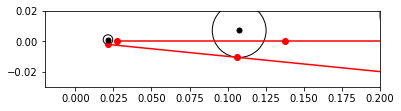

In [48]:
import matplotlib.pyplot as plt
cs = exp_centers
rs = exp_rs
for s in [A,B]:
    plt.plot(s.pts[:, 0], s.pts[:, 1], "r-o")
plt.plot(cs[:, 0], cs[:, 1], "k.", markersize=10)
for i in range(cs.shape[0]):
    plt.gca().add_patch(plt.Circle(cs[i], rs[i], color="k", fill=False))
plt.axis("scaled")
plt.xlim([-0.02,0.2])
plt.ylim([-0.03,0.02])
plt.show()